In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import division
import csv
from datetime import datetime
from collections import Counter

In [72]:
# cool way to import files (like command line)
# !curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_150418.txt

In [73]:
# %%time

# openers = ['turnstile_150418.txt', 'turnstile_150425.txt', 'turnstile_150502.txt', 'turnstile_150509.txt']

# readings = []

# for i in openers:
#     with open(i) as f:
#         reader = csv.reader(f)
#         rows = [[cell.strip() for cell in row] for row in reader]
#         assert rows.pop(0) == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
#                        'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
#                        'EXITS']
#     readings.append(rows)

# dct = {}

# for row in readings:
#     dct.setdefault(tuple(row[:4]), []).append(row[4:])
#     # this produces: "unhashable type: 'list'"

In [74]:
# totally violating DRY :(
##########################
### import 0418 data #####
with open('turnstile_150418.txt') as f:
    reader = csv.reader(f)
    rows = [[cell.strip() for cell in row] for row in reader]
    
assert rows.pop(0) == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
                       'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']
raw_readings_0418 = {}
for row in rows:
    raw_readings_0418.setdefault(tuple(row[:4]), []).append(row[4:])
#########################

#########################
### import 0425 data ####
with open('turnstile_150425.txt') as f:
    reader = csv.reader(f)
    rows = [[cell.strip() for cell in row] for row in reader]
    
assert rows.pop(0) == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
                       'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']

raw_readings_0425 = {}
for row in rows:
    raw_readings_0425.setdefault(tuple(row[:4]), []).append(row[4:])
#########################

#########################
### import 0502 data ####
with open('turnstile_150502.txt') as f:
    reader = csv.reader(f)
    rows = [[cell.strip() for cell in row] for row in reader]
    
assert rows.pop(0) == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
                       'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']
raw_readings_0502 = {}
for row in rows:
    raw_readings_0502.setdefault(tuple(row[:4]), []).append(row[4:])
#########################


### combine into 0418_0502 data
diclist_0418_0502 = [raw_readings_0418, raw_readings_0425 ,raw_readings_0502]

def combine_dics(diclist): # thanks Garrett!
    dic_combined = {}
    for dic in diclist:
        for key, val in dic.iteritems():
            if not key in dic_combined:
                dic_combined[key] = val
            else:
                dic_combined[key] = dic_combined[key] + val
    return dic_combined

dic_0418_0502 = combine_dics(diclist_0418_0502)

In [75]:
raw_readings = dic_0418_0502

### Challenge 2
Let's turn this into a time series. 

For each key (basically the control area, unit, device address and station of a specific turnstile), have a list again, but let the list be comprised of just the point in time and the count of entries.

In [76]:
datetime_cumulative = {turnstile: [[datetime.strptime(date + time,
                                                      '%m/%d/%Y%X'),
                                    int(in_cumulative)]
                                   for _, _, date, time,
                                       _, in_cumulative, _ in rows]
                       for turnstile, rows in raw_readings.items()}

In [77]:
# inspect data
#datetime_cumulative.items()[0]

In [78]:
for rows in datetime_cumulative.values():
    assert rows == sorted(rows)

In [79]:
datetime_count_times = {turnstile: [[rows[i][0],
                                    rows[i+1][1] - rows[i][1],
                                    rows[i+1][0] - rows[i][0]]
                                     for i in range(len(rows) -1)]
                        for turnstile, rows in datetime_cumulative.items()}

In [80]:
all_counts = [count for rows in datetime_count_times.values() for _, count, _ in rows]
all_counts.sort()
print all_counts[-50:]

[3008, 3027, 3049, 3050, 3065, 3075, 3102, 3107, 3118, 3148, 3198, 3400, 3677, 3727, 3823, 4117, 4150, 4270, 4730, 4831, 5037, 5050, 6608, 7074, 7179, 7596, 7779, 7818, 8610, 11728, 12982, 15248, 21585, 40637, 41825, 280665, 280665, 447244, 447792, 448280, 8553144, 23621940, 50331614, 83567603, 116981760, 117439432, 167770787, 1153104117, 1395619898, 1654488698]


In [81]:
all_times = [duration.total_seconds() / 60 / 60
             for rows in datetime_count_times.values()
             for _, _, duration in rows]
print Counter(all_times).most_common(10)

[(4.0, 527494), (4.2, 32287), (8.0, 645), (4.433333333333334, 470), (0.23333333333333334, 241), (0.02222222222222222, 227), (0.022500000000000003, 80), (0.02277777777777778, 52), (3.999722222222222, 48), (4.000277777777778, 47)]


In [82]:
datetime_counts = {turnstile:[(time, count)
                             for time, count, _ in rows
                            if 0<= count <= 5000]
                   for turnstile, rows in datetime_count_times.items()
                  }

### Challenge 3

These counts are for every n hours. (What is n?) We want total daily entries.

Now make it that we again have the same keys, but now we have a single value for a single day, which is the total number of passengers that entered through this turnstile on this day.

In [83]:
day_counts = {}
for turnstile, rows in datetime_counts.items():
    byDay = {}
    for time, count in rows:
        day = time.date()
        byDay[day] = byDay.get(day, 0) + count
    day_counts[turnstile] = sorted(byDay.items())

In [84]:
# inspect data
#sorted(day_counts.items()[:4])

### Challenge 4

We will plot the daily time series for a turnstile.

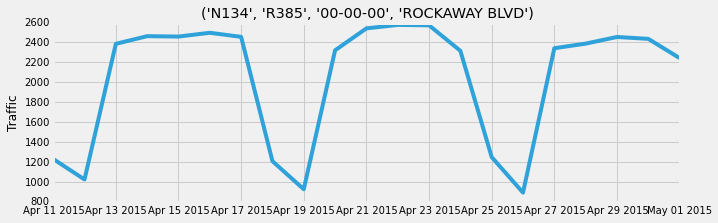

In [85]:
turnstile = day_counts.values()[1] # this is just for one turnstile

dates = []
counts = []

for x, y in turnstile:
    dates.append(x)
    counts.append(y)


with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(10,3))
    plt.ylabel('Traffic')
    plt.title(day_counts.keys()[1]) # title of graph
    plt.plot(dates,counts) # data for the graph

plt.show()

### Challenge 5
So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, different values for the SCP column.

We want to combine the numbers together -- for each ControlArea / UNIT / STATION combo, for each day, add the counts from each turnstile belonging to that combo.

In [86]:
## Add up by turnstiles
crunched_dict = {}

for old_key, old_value in day_counts.items():
    new_key = (old_key[0], old_key[1], old_key[3])
    crunched_dict[new_key] = crunched_dict.get(new_key, []) + old_value

# this solves the problem of adding up by turnstiles, but not aggregating by day

In [87]:
# now group the new keys by day
crunched_dict_right ={}

for new_turn, new_value in crunched_dict.items():
    by_day ={}
    for time, count in new_value:
        by_day[time] = by_day.get(time, 0) + count
    crunched_dict_right[new_turn] = sorted(by_day.items())

#inspect data
#crunched_dict_right.items()[:2]

## Challenge 6
Similarly, combine everything in each station, and come up with a time series of `[(date1, count1),(date2,count2),...]` type of time series for each STATION, by adding up all the turnstiles in a station.

In [88]:
## Add up by stations
station_dict = {}

for old_key, old_value in crunched_dict_right.items():
    new_key = (old_key[2])
    station_dict[new_key] = station_dict.get(new_key, []) + old_value

# this solves the problem of adding up by station, but not aggregating by day

In [89]:
# Now collapse by day
crunched_by_station ={}

for new_turn, new_value in station_dict.items():
    by_day ={}
    for time, count in new_value:
        by_day[time] = by_day.get(time, 0) + count
    crunched_by_station[new_turn] = sorted(by_day.items())

## Challenge 7
Plot the time series for a station.

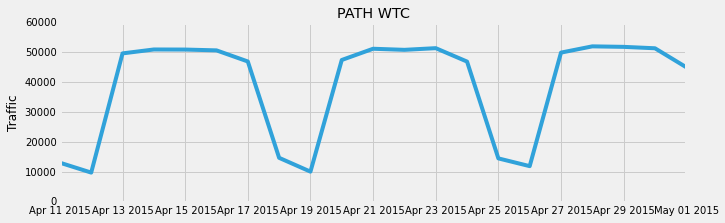

In [90]:
# select a station by i

i = 2

station = crunched_by_station.values()[i] 

dates = []
counts = []

for x, y in station:
    dates.append(x)
    counts.append(y)

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(10,3))
    plt.ylabel('Traffic')
    plt.title(crunched_by_station.keys()[i]) # title of graph
    plt.plot(dates,counts) # data for the graph

plt.show()

## Challenge 8
Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. `plt.plot(week_count_list)` for every `week_count_list` you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

In [91]:
def week_count(start=0, stop=7):
    
    week_count_list = [] # just a list for one station, one week

    for time, value in crunched_by_station.items()[1][1][start:stop]:
        #day = time.strftime("%a")
        week_count_list.append([time.weekday(), value])

    return week_count_list

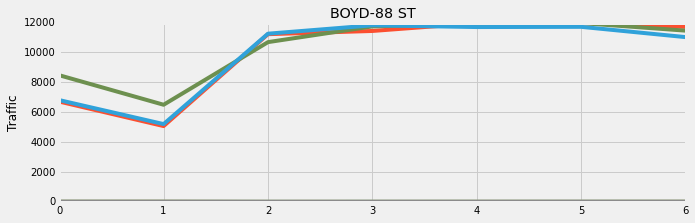

In [93]:
# plot three weeks

#labels = ['Sat', 'Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri']
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(10,3))
    plt.ylabel('Traffic')
    #plt.xticks(labels) this didn't work
    plt.title(crunched_by_station.items()[0][0]) # title of graph
    plt.plot(week_count()) 
    plt.plot(week_count(7,14))
    plt.plot(week_count(14,21))
plt.show()

## Challenge 9
Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [94]:
# combine counts for the 3 weeks by station
big_dict ={}
for k, v in crunched_by_station.items():
    tot = sum([val[1] for val in v])
    big_dict[k] = (tot)
    
big_dict.items()[:5]

[('BOYD-88 ST', 52303),
 ('NEWKIRK PLAZA', 212300),
 ('PATH WTC', 821464),
 ('TREMONT AVE', 188958),
 ('22 AVE-BAY PKY', 30666)]

In [95]:
# sort the dictionary by values in decending order
top_5 = sorted(big_dict.items(), key = lambda x:x[1], reverse = True)[:5]

In [96]:
top_5

[('34 ST-PENN STA', 3258516),
 ('42 ST-GRD CNTRL', 2787193),
 ('34 ST-HERALD SQ', 2263108),
 ('86 ST', 2185198),
 ('14 ST-UNION SQ', 2131164)]

## Challenge 10
Make a single list of these total ridership values and plot it with `plt.hist(total_ridership_counts)` to get an idea about the distribution of total ridership among different stations.

This should show you that most stations have a small traffic, and the histogram bins for large traffic volumes have small bars.

In [97]:
# make a list of the ridership values from stations

ridership_vals = [val for _, val in big_dict.items()]
ridership_vals[:4]

[52303, 212300, 821464, 188958]

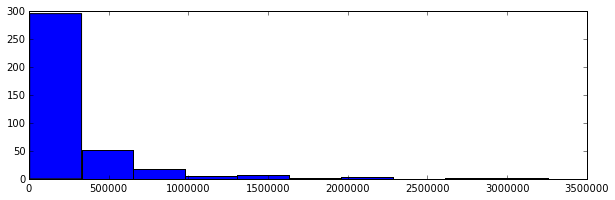

In [98]:
plt.figure(figsize=(10,3))
plt.hist(ridership_vals)
plt.show()

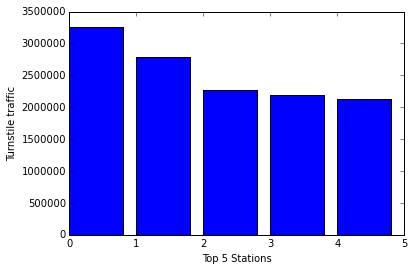

In [99]:
places = []
counts = []

indices = range(len(top_5))

for x, y in top_5:
    places.append(x)
    counts.append(y)
    
plt.bar(indices, counts)
plt.xlabel('Top 5 Stations')
plt.ylabel('Turnstile traffic')
plt.show()
# Sadly I was unable to figure out how to make this graph have the right labels :(